In [1]:
# Will Hollingsworth, Colton Murray, Alexander Shiveley

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Getting the data into Python

In [3]:
# Load the csv as a numpy array of strings, 
# because it includes the column headers
raw_data = np.loadtxt('iris.csv', delimiter=',', dtype=str)

# Grab the headers
header_list = raw_data[0].tolist()

# Remove the headers from the data
stripped = np.delete(raw_data, [0], axis=0)

# We specifically want to know if a sample is setosa or NOT setosa
def apply_mapping(row):
    row[4] = 1 if row[4] == 'setosa' else 0
    return row

# Convert species to a numeric value
converted = np.apply_along_axis(apply_mapping, 1, stripped)

# Convert everything into floats!
clean_data = np.array(converted, dtype=float)

In [4]:
clean_data

array([[5.1, 3.5, 1.4, 0.2, 1. ],
       [4.9, 3. , 1.4, 0.2, 1. ],
       [4.7, 3.2, 1.3, 0.2, 1. ],
       [4.6, 3.1, 1.5, 0.2, 1. ],
       [5. , 3.6, 1.4, 0.2, 1. ],
       [5.4, 3.9, 1.7, 0.4, 1. ],
       [4.6, 3.4, 1.4, 0.3, 1. ],
       [5. , 3.4, 1.5, 0.2, 1. ],
       [4.4, 2.9, 1.4, 0.2, 1. ],
       [4.9, 3.1, 1.5, 0.1, 1. ],
       [5.4, 3.7, 1.5, 0.2, 1. ],
       [4.8, 3.4, 1.6, 0.2, 1. ],
       [4.8, 3. , 1.4, 0.1, 1. ],
       [4.3, 3. , 1.1, 0.1, 1. ],
       [5.8, 4. , 1.2, 0.2, 1. ],
       [5.7, 4.4, 1.5, 0.4, 1. ],
       [5.4, 3.9, 1.3, 0.4, 1. ],
       [5.1, 3.5, 1.4, 0.3, 1. ],
       [5.7, 3.8, 1.7, 0.3, 1. ],
       [5.1, 3.8, 1.5, 0.3, 1. ],
       [5.4, 3.4, 1.7, 0.2, 1. ],
       [5.1, 3.7, 1.5, 0.4, 1. ],
       [4.6, 3.6, 1. , 0.2, 1. ],
       [5.1, 3.3, 1.7, 0.5, 1. ],
       [4.8, 3.4, 1.9, 0.2, 1. ],
       [5. , 3. , 1.6, 0.2, 1. ],
       [5. , 3.4, 1.6, 0.4, 1. ],
       [5.2, 3.5, 1.5, 0.2, 1. ],
       [5.2, 3.4, 1.4, 0.2, 1. ],
       [4.7, 3

In [5]:
def split_input_output(data):
    """
    Splits the input array into two seperate sets:
        * the feature values
        * the output value
        
    :returns: (tuple) the features are the first element, the outputs are the second
    """
    return np.delete(data, [data.shape[1] - 1], axis=1), data[:, -1]

In [6]:
x, y = split_input_output(clean_data)
x, y

(array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
        [5

In [7]:
# we also probably want to be able to separate our positive and negative examples
def split_pos_neg(data):
    """
    Returns two sets of positive, then negative examples (1's then 0's from the output column)
    """
    return data[data[:, -1]==1, :-1], data[data[:, -1]==0, :-1]

In [8]:
pos, neg = split_pos_neg(clean_data)

# Histograms

In [9]:
def get_range(data, attribute):
    return data[:, attribute].min(), data[:, attribute].max()

def get_bin_edges(data, attribute, num_bins):
    l, h = get_range(data, attribute)
    
    step = (h - l) / num_bins
    edges = np.arange(num_bins + 1)
    return (edges * step) + l

def hist(data, attribute, num_bins):
    """
    Produces two histograms, one for positive and one for negative examples.
    Calculates the bins from the entire data set.
    
    :param data: The TOTAL data set
    :attribute: the attribute (column index) you'd like to histogram
    :num_bins: the number of bins for the histogram
    """
    edges = get_bin_edges(data, attribute, num_bins)
    pos, neg = split_pos_neg(data)
    
    h_pos, _ = np.histogram(pos[:, attribute], edges)
    h_neg, _ = np.histogram(neg[:, attribute], edges)
    
    return h_pos, h_neg, edges
    

In [10]:
h_pos, h_neg, e = hist(clean_data, 2, 5)
h_pos, h_neg, e

(array([50,  0,  0,  0,  0], dtype=int64),
 array([ 0,  3, 34, 47, 16], dtype=int64),
 array([1.  , 2.18, 3.36, 4.54, 5.72, 6.9 ]))

In [11]:
# ^ Notice how they're completely separate for petal length

# Entropy

In [12]:
def total_entropy(data_set):
    """
    Calculates the entropy of a data set.
    Assumes that the final column is the classification for each sample.
    """
    x, y = split_input_output(data_set)
    
    # get the possible output values, and their totals
    values, counts = np.unique(y, return_counts=True)
    entropy = 0
    for count in counts:
        p = count / sum(counts)   
        entropy -= p * math.log(p, 2)
        # Alex - I know the base should be len(values), but in most cases this is 2 for this assignment.
        # It caused issues for me in ID3 if len(values) was 1
        
    return entropy

def bucket_entropy(pos_count, neg_count):
    if pos_count == 0 or neg_count == 0:
        return 0
    
    p = pos_count / (pos_count + neg_count)
    return -p * math.log(p, 2)


def info_gained(data_set, attribute, num_bins):
    h_pos, h_neg, _ = hist(data_set, attribute, num_bins)
    
    tot_entropy = total_entropy(data_set)
    for i in range(len(h_pos)):
        bin_size_ratio = (h_pos[i] + h_neg[i]) / data_set.shape[0]
        tot_entropy -= bin_size_ratio * bucket_entropy(h_pos[i], h_neg[i])
        
    return tot_entropy

In [13]:
total_entropy(clean_data)

0.9182958340544896

In [14]:
info_gained(clean_data, 2, 5)

0.9182958340544896

In [15]:
# ^ In this specific case, we gained ALL the info because the samples are perfectly seperated by petal length
# Theoretically, we would check every attribute and choose whichever one yielded the highest gain
# Then split our data_set by the bins of the histogram, if a bin has all the same kind of output we can stop there,
# but if there are still bins with both kinds of output we repeat this info_gained on a new attribute for that bin.

In [16]:
# RESOLVED: make sure we're doing the bins right? the homework mentions rounding to the nearest integer, 
# currently we're just evenly splitting across the range of the attribute
# Alex - I'm not sure. This doesn't make sense since one attribute ranges from about 0 to 3,
# and rounding to ints won't work too well
# Will - agreed

# RESOLVED: actually form the tree? I don't think it's actually necessary but usually you would actually output the tree with
# the sequences of tests it performs on which attributes
# Alex - I went ahead and generated a tree in order to run the test data against.
# I agree that it's not needed, but might be nice as output for the assignment. And it's not much extra work.

# RESOLVED (kinda): Will - made accuracy print out for ID3.

In [17]:
info_gained(clean_data, 0, 5)

0.711253795229212

# ID3

In [18]:
def in_range(value, val_range):
    return value >= val_range[0] and value < val_range[1]

def id3_filter_data(data_set, attribute, val_range):
    rows = []
    for row in range(data_set.shape[0]):
            if in_range(data_set[row, attribute], val_range):
                rows.append(row)
    return data_set[rows, :]

def id3_generate_tree(data_set, num_bins, decision_tree=None, used_attr=None):
    """
    Recursively produces an ID3 tree based on the data set and number of bins.
    
    :param data_set: The TOTAL data set for this node or entire tree
    :num_bins: the number of bins for the histogram
    :decision_tree: the subtree to expand
    :used_attr: list of used attributes so far down this branch
    """     
    # Start with a root node if tree is empty
    if decision_tree is None:
        decision_tree = {"attribute": None, "range": None, "children": [], "split": None}
    # Start with empty list of used attributes
    if used_attr is None:
        used_attr = []    
    
    # Find the attribute with the highest information gain, if the attribute is unused
    best_attr = None
    for attr in range(0, data_set.shape[1] - 1):
        if not attr in used_attr:
            if best_attr is None or info_gained(data_set, attr, num_bins) > info_gained(data_set, best_attr, num_bins):
                best_attr = attr
    if best_attr is not None:
        decision_tree["attribute"] = best_attr
        used_attr.append(best_attr)
    
    # Get the histograms for the best attribute and the edges
    h_pos, h_neg, e = hist(data_set, best_attr, num_bins)
    # Add a node to the tree for each bin
    for i in range(len(h_pos)):  
        child = {}
        # The range of the best attribute for this bin. Allow for bounds to infinities on ends of histogram
        val_range = (e[i] if i > 0 else float('-inf'), e[i + 1] if i < len(h_pos) - 1 else float('inf'))
        
        # If the bin is all positive, all negative, empty?, or there are no unused attributes left, create a leaf node
        if h_pos[i] > 0 and h_neg[i] == 0 or h_pos[i] == 0 and h_neg[i] > 0 or h_pos[i] == 0 or best_attr == None:
            split = (h_pos[i], h_neg[i])
            child = {"attribute": None, "range": val_range, "children": [], "split": split}      
        # Else expand the bin using the filtered dataset for that bin    
        else:
            child = id3_generate_tree(id3_filter_data(data_set, best_attr, val_range), num_bins, {"attribute": None, "range": val_range, "children": [], "split": None}, used_attr.copy())
        
        decision_tree["children"].append(child)
    return decision_tree

def id3_range_str(val_range):
    """
    Print the range, accounting for infinities
    """
    if val_range[0] == float('-inf'):
        return "<  " + str(val_range[1])
    if val_range[1] == float('inf'):
        return ">= " + str(val_range[0])
    return "in [" + str(val_range[0]) + ", " + str(val_range[1]) + ")"

def id3_print_tree(tree, depth = 0):
    for child in tree["children"]:        
        print("    " * depth, "Attribute", tree["attribute"], id3_range_str(child["range"]), ": " + str(child["split"]) if child["split"] != None else "")
        id3_print_tree(child, depth + 1)

In [19]:
def id3_p(x, decision_tree):
    """
    Get the probability for the point being classified positive by the tree
    """
    node = decision_tree
    while node["split"] is None:
        for child in node["children"]:   
            if in_range(x[node["attribute"]], child["range"]):
                node = child
                break
    # return Num Pos / (Num Pos + Num Neg) or 0 if empty
    return (node["split"][0] / (node["split"][0] + node["split"][1])) if (node["split"][0] + node["split"][1]) > 0 else 0

def id3_classify(x_data_set, decision_tree):
    """
    Classify y values for the data set using a decision tree
    
    :param x_data_set: The x part of the data set
    :decision_tree: the tree to classify each point
    """     
    y_matrix = np.empty((x_data_set.shape[0], 1))
    for row in range(x_data_set.shape[0]):
        y_matrix[row, 0] = id3_p(x_data_set[row, :], decision_tree)
    return y_matrix

In [20]:
id3_tree = id3_generate_tree(clean_data, 2)
id3_print_tree(id3_tree)
id3_classify(clean_data, id3_tree) #RESOLVED: Replace clean_data with test data once splitting of training/test data is done
# ^ See get_sets

 Attribute 2 <  3.95 
     Attribute 3 <  0.7499999999999999 : (50, 0)
     Attribute 3 >= 0.7499999999999999 : (0, 11)
 Attribute 2 >= 3.95 : (0, 89)


array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],

In [21]:
# And I'm not sure what to do with ID3 if a bin is empty. Right now it just has it as a leaf node and will classify as negative
# if the bin is empty and a test data point happens to fall in that bin
# Will - that's technically what you're supposed to do because 0 is more common than 1. 
#(You're supposed to output whatever is more common)

In [22]:
def get_sets(data, split):
    """
    Convenience function that randomly selects a training and test set from the input data.
    
    :param data: (ndarray) the data you want to split
    :param split: (float) the percentage of the data you want to be TRAINING data
    
    :returns: (tuple) a tuple where the first element is the training set, and the second element is the test set
    """
    # Randomly shuffle the order from a copy of the data
    shuffled = data.copy()
    np.random.shuffle(shuffled)

    row_count = data.shape[0]

    # calc the number of samples, assumes the input samples are seperated by row
    training_count = round(row_count * split)
    
    training_set = shuffled[:training_count]
    test_set = shuffled[training_count:]
    
    return training_set, test_set

In [23]:
train, test = get_sets(clean_data, 2/3)

In [24]:
len(train)

100

In [25]:
tree = id3_generate_tree(clean_data, 5)
classified = id3_classify(test, tree)

In [26]:
def accuracy(classified, test):
    comp = (classified[:, -1] == test[:, -1])
    return np.count_nonzero(comp) / len(comp)

In [27]:
accuracy(classified, test)

1.0

In [28]:
def precision(classified, test):
    tp_comp = np.logical_and(classified[:, -1] == 1, test[:, -1] == 1)
    p_comp = (classified[:, -1] == 1)
    return np.count_nonzero(tp_comp) / np.count_nonzero(p_comp)

In [29]:
precision(classified, test)

1.0

In [30]:
def recall(classified, test):
    tp_comp = np.logical_and(classified[:, -1] == 1, test[:, -1] == 1)
    fn_comp = np.logical_and(classified[:, -1] == 0, test[:, -1] == 1)
    return np.count_nonzero(tp_comp) / (np.count_nonzero(tp_comp) + np.count_nonzero(fn_comp))

In [31]:
recall(classified, test)

1.0

In [32]:
def f1_score(classified, test):
    p = precision(classified, test)
    r = recall(classified, test)
    return (2 * p * r) / (p + r)

In [33]:
f1_score(classified, test)

1.0

In [34]:
def roc(test, p_fn, y_classified):
    points_x = []
    points_y = []
    for t in np.arange(1, -.01, -.01):
        fp = 0
        tp = 0
        for row in range(test.shape[0]):
            if p_fn(test[row, :]) >= t:
                if y_classified[row] == 1:
                    tp = tp + 1
                else:
                    fp = fp + 1
        pos = np.count_nonzero(y_classified)
        neg = y_classified.shape[0] - pos
        tpr = tp / pos
        fpr = fp / neg
        points_x.append(fpr)
        points_y.append(tpr)
    return points_x, points_y

In [35]:
# Convenience function to run all of the id3 trials
def run_id3_trials(data):
    
    accs = {}
    f1s = {}
    rocs = {}
    for bins in range(5, 25, 5):
        accs[bins] = []
        f1s[bins] = []
        sets = [get_sets(clean_data, 2/3), get_sets(clean_data, 2/3), get_sets(clean_data, 2/3), get_sets(clean_data, 2/3), get_sets(clean_data, 2/3)]
        for s in sets:
            tree = id3_generate_tree(s[0], bins)
            c = id3_classify(s[1], tree)
            accs[bins].append(accuracy(c, s[1]))
            f1s[bins].append(f1_score(c, s[1])) 
            rocs[bins] = roc(s[1], lambda x: id3_p(x, tree), c)
            
    for b in accs:
        print(f"Bins: {b}")
        print(f"\tAccuracies: {accs[b]}")
        print(f"\tMin Acc: {min(accs[b])}")
        print(f"\tMax Acc: {max(accs[b])}")
        print(f"\tAvg Acc: {np.average(accs[b])}")
    
    for b in accs:
        x = np.arange(1, 6, 1)
        plt.plot(x, accs[b], '--r', label='Accuracy')
        plt.legend()
        plt.ylim((.5, 1.1)) 
        plt.xlabel("Trial")
        plt.ylabel("Accuracy")
        plt.title("Accuracy Across Trials for Bins: " + str(b))
        plt.xticks(x)
        plt.show()
        
        
    x = np.arange(1, 6, 1)
    plt.plot(x, f1s[5], '--r', label='F1 Score Bins: 5')
    plt.plot(x, f1s[10], '--g', label='F1 Score Bins: 10')
    plt.plot(x, f1s[15], '--b', label='F1 Score Bins: 15')
    plt.plot(x, f1s[20], '--y', label='F1 Score Bins: 20')
    plt.legend()
    plt.ylim((.5, 1.1)) 
    plt.xlabel("Trial")
    plt.ylabel("Score")
    plt.title("F1 Scores Across Trials")
    plt.xticks(x)
    plt.show()    
    
    plt.plot(rocs[5][0], rocs[5][1], 'ro', label='ROC Curve Bins: 5')
    plt.plot(rocs[10][0], rocs[10][1], 'go', label='ROC Curve Bins: 10')
    plt.plot(rocs[15][0], rocs[15][1], 'bo', label='ROC Curve Bins: 15')
    plt.plot(rocs[20][0], rocs[20][1], 'yo', label='ROC Curve Bins: 20')
    plt.legend()
    plt.xlabel("TPR")
    plt.ylabel("FPR")
    plt.title("ROC Curve")
    plt.xlim((-.1, 1.1)) 
    plt.ylim((-.1, 1.1)) 
    plt.show()

Bins: 5
	Accuracies: [1.0, 1.0, 1.0, 1.0, 1.0]
	Min Acc: 1.0
	Max Acc: 1.0
	Avg Acc: 1.0
Bins: 10
	Accuracies: [1.0, 1.0, 1.0, 1.0, 1.0]
	Min Acc: 1.0
	Max Acc: 1.0
	Avg Acc: 1.0
Bins: 15
	Accuracies: [1.0, 1.0, 1.0, 1.0, 1.0]
	Min Acc: 1.0
	Max Acc: 1.0
	Avg Acc: 1.0
Bins: 20
	Accuracies: [1.0, 1.0, 1.0, 0.96, 1.0]
	Min Acc: 0.96
	Max Acc: 1.0
	Avg Acc: 0.992


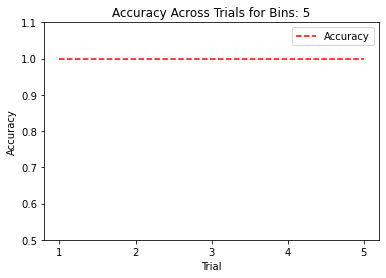

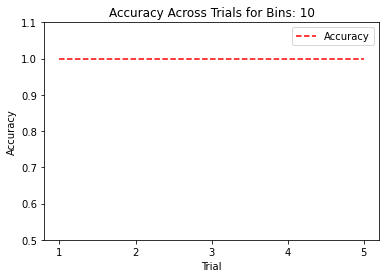

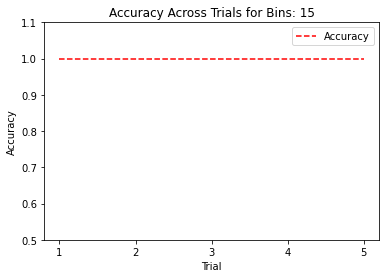

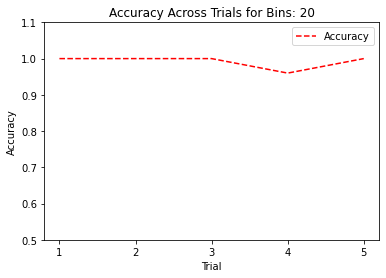

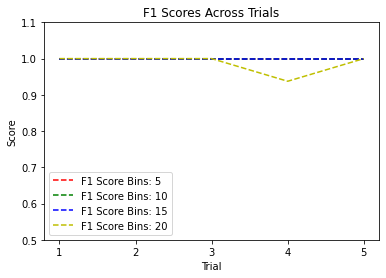

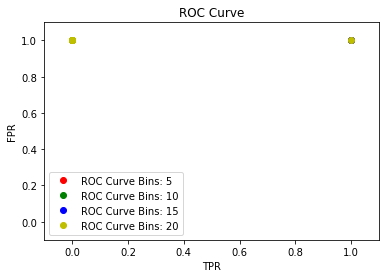

In [36]:
run_id3_trials(clean_data)

In [37]:
# Apparently 15 bins is just bad.
# Alex seems like 15 and 20 randomly have 100% accuracy and sometimes not. but 15 is mroe common.

In [38]:
# ROC may not be correct, especially the p_fn part. This didn't seem to be explained too well 
# but I think for ID3 it's the probability based on the bin's split between pos/neg.
# not sure about Bayes